# Flight Patterns Clustering using ML Algorithms

<img src="airliners.png" alt="Logo" style="width:90%;height:60%"/>


## Importing Modules


import pandas as pd
import numpy as np
import hashlib
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import haversine
from folium.plugins import HeatMap
from folium import PolyLine
import sqlite3
from shapely.geometry import Point
from scipy.stats import linregress
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML


## Data Extraction

In [2]:
# Connect to the SQLite database to extract data
conn = sqlite3.connect('flight_data.db')

# Execute an SQL query to select all columns from the flight_data table and mask the aircraft_icao_id
query = '''SELECT * FROM flight_data'''

query2 = '''SELECT * FROM navigation_data'''

# Ingest db data into a pandas dataframe
df = pd.read_sql(query, conn)
df1 = pd.read_sql(query2, conn)


# Close the database connection
conn.close()




## Exploratory Data Analysis

<p><b> EDA is an essential step in the data analysis process where we aim to understand the structure of the data, identify any data quality issues, and gain insights into its distribution and summary statistics The aircraft_icao_id field is masked and then scrambled to preserve data confidentiality.</b></p>

In [4]:
# Define the masking function
def mask_id(id):
    return 'Masked' if id else id



<p><b> Preview the datasets</b></p>

In [5]:
df.head().assign(aircraft_icao_id=df.head()['aircraft_icao_id'].apply(mask_id))




,id,message_type,aircraft_icao_id,date,timestamp,altitude,latitude,longitude
0,1,MSG3,Masked,2023/10/21,00:42:56.675,33025.0,38.3421,-89.66679
1,2,MSG3,Masked,2023/10/21,00:43:07.514,33225.0,38.3158,-89.65011
2,3,MSG3,Masked,2023/10/21,00:43:07.598,19475.0,38.42478,-89.93286
3,4,MSG3,Masked,2023/10/21,00:43:27.890,20350.0,38.40276,-89.88032
4,5,MSG3,Masked,2023/10/21,00:43:48.782,21150.0,38.3799,-89.82577


In [6]:
print('The dataframe has {} rows and {} attributes'.format(df.shape[0],df.shape[1]))

The dataframe has 7453 rows and 8 attributes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7453 entries, 0 to 7452
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7453 non-null   int64 
 1   message_type      7453 non-null   object
 2   aircraft_icao_id  7453 non-null   object
 3   date              7453 non-null   object
 4   timestamp         7453 non-null   object
 5   altitude          7453 non-null   object
 6   latitude          7453 non-null   object
 7   longitude         7453 non-null   object
dtypes: int64(1), object(7)
memory usage: 465.9+ KB


<p><b> Looking for duplicates records and null values/blank space</b></p>

In [8]:
df.isnull().any()

id                  False
message_type        False
aircraft_icao_id    False
date                False
timestamp           False
altitude            False
latitude            False
longitude           False
dtype: bool

In [9]:
df.duplicated().any()

False

In [10]:
df.duplicated(subset=['aircraft_icao_id','date']).any()

True

In [11]:
(df == '').any()

id                  False
message_type        False
aircraft_icao_id    False
date                False
timestamp           False
altitude             True
latitude             True
longitude            True
dtype: bool

In [12]:
df1.head().assign(aircraft_icao_id=df1.head()['aircraft_icao_id'].apply(mask_id))




,id,message_type,aircraft_icao_id,date,timestamp,speed,heading
0,1,MSG4,Masked,2023/10/21,00:43:28.651,501.0,118.0
1,2,MSG4,Masked,2023/10/21,00:43:49.252,506.0,118.0
2,3,MSG4,Masked,2023/10/21,00:44:09.362,495.0,209.0
3,4,MSG4,Masked,2023/10/21,00:44:40.341,495.0,209.0
4,5,MSG4,Masked,2023/10/21,00:45:03.788,494.0,209.0


In [13]:
print('The dataframe has {} rows and {} attributes'.format(df1.shape[0],df1.shape[1]))

The dataframe has 6348 rows and 7 attributes


In [14]:
df1.isnull().any()

id                  False
message_type        False
aircraft_icao_id    False
date                False
timestamp           False
speed               False
heading             False
dtype: bool

In [15]:
(df1 == '').any()

id                  False
message_type        False
aircraft_icao_id    False
date                False
timestamp           False
speed               False
heading             False
dtype: bool

In [16]:
df1.duplicated().any()

False

In [17]:
df1.duplicated(subset=['aircraft_icao_id','date']).any()

True

### Data Cleaning
<p><b>Exploring dataframes data types </b></p>

In [18]:
df.dtypes

id                   int64
message_type        object
aircraft_icao_id    object
date                object
timestamp           object
altitude            object
latitude            object
longitude           object
dtype: object

In [19]:
df1.dtypes

id                    int64
message_type         object
aircraft_icao_id     object
date                 object
timestamp            object
speed               float64
heading             float64
dtype: object

<p><b>Replacing possible white space with nan values.</b></p>

In [20]:

df.replace('', np.nan, inplace=True)

In [21]:
df.isna().any()

id                  False
message_type        False
aircraft_icao_id    False
date                False
timestamp           False
altitude             True
latitude             True
longitude            True
dtype: bool

<p><b>Removing rows with null/blank values.</b></p>

In [22]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [23]:
(df=='').any()

id                  False
message_type        False
aircraft_icao_id    False
date                False
timestamp           False
altitude            False
latitude            False
longitude           False
dtype: bool

In [24]:
(df1=='').any()

id                  False
message_type        False
aircraft_icao_id    False
date                False
timestamp           False
speed               False
heading             False
dtype: bool

<p><b> Enforcing the correct data types.</b></p>

In [25]:
df['message_type'] = df['message_type'].astype(str)
df['aircraft_icao_id'] = df['aircraft_icao_id'].astype(str)
df['altitude'] = df['altitude'].astype(int)
df['date'] = pd.to_datetime(df['date'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f', errors='coerce').dt.strftime('%H:%M:%S.%f')



In [26]:
df1['message_type'] = df1['message_type'].astype(str)
df1['aircraft_icao_id'] = df1['aircraft_icao_id'].astype(str)
df1['date'] = pd.to_datetime(df1['date'])
df1['timestamp'] = pd.to_datetime(df1['timestamp'], format='%H:%M:%S.%f', errors='coerce').dt.strftime('%H:%M:%S.%f')
df1['speed'] = df1['speed'].astype(int)
df1['heading'] = df1['heading'].astype(int)


In [27]:
# sorting values by aircrart_icao_id and timestamp
df.sort_values(by=['aircraft_icao_id', 'timestamp'], inplace=True)
df.head().assign(aircraft_icao_id=df.head()['aircraft_icao_id'].apply(mask_id))

,id,message_type,aircraft_icao_id,date,timestamp,altitude,latitude,longitude
4362,4892,MSG3,Masked,2023-10-26,23:16:29.707000,35000,38.61955,-90.12807
4365,4895,MSG3,Masked,2023-10-26,23:17:11.591000,35000,38.55450,-90.03272
4369,4899,MSG3,Masked,2023-10-26,23:18:27.616000,35000,38.44043,-89.86631
4373,4903,MSG3,Masked,2023-10-26,23:20:11.634000,35000,38.28525,-89.64189
4376,4906,MSG3,Masked,2023-10-26,23:20:54.755000,35000,38.22078,-89.54956


In [28]:
print('The dataframe has {} rows and {} attributes'.format(df.shape[0],df.shape[1]))

The dataframe has 6740 rows and 8 attributes


In [29]:
df1.sort_values(by=['aircraft_icao_id', 'timestamp'], inplace=True)
df1.head().assign(aircraft_icao_id=df1.head()['aircraft_icao_id'].apply(mask_id))

,id,message_type,aircraft_icao_id,date,timestamp,speed,heading
4041,4042,MSG4,Masked,2023-10-26,23:17:12.061000,510,131
4046,4047,MSG4,Masked,2023-10-26,23:19:19.891000,490,131
4047,4048,MSG4,Masked,2023-10-26,23:19:39.813000,492,131
4048,4049,MSG4,Masked,2023-10-26,23:19:50.772000,492,131
4051,4052,MSG4,Masked,2023-10-26,23:20:43.824000,487,132


In [30]:
print('The dataframe has {} rows and {} attributes'.format(df1.shape[0],df1.shape[1]))

The dataframe has 6348 rows and 7 attributes


<p><b> Data Transformation</b></p>

<p><b>Merging dataframes df and df1 into a new dataframe new_df</b></p>

In [31]:
new_df = df.merge(df1,on=['aircraft_icao_id', 'date'],how='inner')
new_df = new_df[new_df['timestamp_y'] > new_df['timestamp_x']]
print('The dataframe has {} rows and {} attributes'.format(new_df.shape[0],new_df.shape[1]))

The dataframe has 21555 rows and 13 attributes


<p><b>Hash the 'aircraft_icao_id' column using SHA-256 from hashlib and shuffle timestamp field.</b></p>

In [32]:
# Hash the 'aircaft_icao_id' column using SHA-256 from hashlib
def sha256_hash(value):
    sha256 = hashlib.sha256()
    sha256.update(str(value).encode('utf-8'))
    return sha256.hexdigest()

new_df['aircraft_icao_id'] = new_df['aircraft_icao_id'].apply(sha256_hash)




In [33]:
new_df.head()


,id_x,message_type_x,aircraft_icao_id,date,timestamp_x,altitude,latitude,longitude,id_y,message_type_y,timestamp_y,speed,heading
0,4892,MSG3,ae1acd3c96ca339c5a751a84414d159d851c1ed5467088...,2023-10-26,23:16:29.707000,35000,38.61955,-90.12807,4042,MSG4,23:17:12.061000,510,131
1,4892,MSG3,ae1acd3c96ca339c5a751a84414d159d851c1ed5467088...,2023-10-26,23:16:29.707000,35000,38.61955,-90.12807,4047,MSG4,23:19:19.891000,490,131
2,4892,MSG3,ae1acd3c96ca339c5a751a84414d159d851c1ed5467088...,2023-10-26,23:16:29.707000,35000,38.61955,-90.12807,4048,MSG4,23:19:39.813000,492,131
3,4892,MSG3,ae1acd3c96ca339c5a751a84414d159d851c1ed5467088...,2023-10-26,23:16:29.707000,35000,38.61955,-90.12807,4049,MSG4,23:19:50.772000,492,131
4,4892,MSG3,ae1acd3c96ca339c5a751a84414d159d851c1ed5467088...,2023-10-26,23:16:29.707000,35000,38.61955,-90.12807,4052,MSG4,23:20:43.824000,487,132


<p><b>Removing duplicate rows (same aircraft_icao_id and date),drop additional fields, and rename the timestamp_x column to jus timestamp.</b></p>


In [34]:
new_df.drop_duplicates(subset=['aircraft_icao_id', 'date'],inplace=True)

In [35]:

new_df.drop(['id_x','id_y','message_type_x','message_type_y','timestamp_y'],axis=1,inplace=True)



In [36]:
new_df.rename(columns={'timestamp_x': 'timestamp'},inplace=True)
new_df.reset_index(drop=True, inplace=True)



In [37]:
# Shuffle the 'timestamp' column in new_df
new_df['timestamp'] = np.random.permutation(new_df['timestamp'])

<p><b>Creating a new field, Distance, defined as the distance (Radius of the hearth in kilomoters) from each airplane and a fixed location in Illinois </b></p>

In [38]:
# ADSB Receiver coordinates (latitude and longitude)
fixed_place = {
    'latitude': 38.552427,
    'longitude': -89.923652
}


In [39]:

def calculate_haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth's surface.

    The Haversine formula is used to compute the great-circle distance between two points
    on the Earth's surface, given their latitude and longitude in degrees.

    Parameters:
    lat1 (float): Latitude of the first point in degrees.
    lon1 (float): Longitude of the first point in degrees.
    lat2 (float): Latitude of the second point in degrees.
    lon2 (float): Longitude of the second point in degrees.

    Returns:
    distance (float): The Haversine distance between the two points in kilometers.

    Notes:
    - The Haversine formula assumes a spherical Earth, which may not be completely accurate.
      For high-precision applications, consider using more complex models.
    - The result of this calculation is the distance between the two points along the surface
      of a sphere, not accounting for variations in altitude.
    """

    # Radius of the Earth in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c

    return distance

# adding a new field to the dataframe new_df
new_df['Distance_From_Receiver'] = new_df.apply(
    lambda row: calculate_haversine(row['latitude'], row['longitude'], fixed_place['latitude'], fixed_place['longitude']),
    axis=1
)


<p><b>Preview the dataset</b></p>

In [40]:
new_df.head()

,aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
0,ae1acd3c96ca339c5a751a84414d159d851c1ed5467088...,2023-10-26,20:06:24.878000,35000,38.61955,-90.12807,510,131,19.271622
1,0558783c508dd8ceb8f9bde499f63ccfdf1f77eace6ad0...,2023-10-21,02:25:26.486000,40000,38.84384,-90.11713,487,202,36.495388
2,891029be8c1a1d09c626a8623b6672bd11cb79b558d6a4...,2023-10-22,01:47:50.346000,37975,38.55801,-89.70074,415,206,19.393315
3,5c075566142f83bda2d7dfb4e588df0301700c9c8f4785...,2023-10-21,22:35:01.245000,37950,38.66107,-90.23029,432,214,29.255380
4,077ac534a657b6d2fe1fff7572b3bd1fdc60b0941ecd84...,2023-10-22,03:41:21.108000,36025,38.72662,-89.94680,435,210,19.473439


In [41]:
print('The dataframe has {} rows and {} attributes'.format(new_df.shape[0],new_df.shape[1]))

The dataframe has 1032 rows and 9 attributes


In [42]:
# exporting data to a csv file
new_df.to_csv('syntethic_flight_data.csv', index=False) 


In [43]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   aircraft_icao_id        1032 non-null   object        
 1   date                    1032 non-null   datetime64[ns]
 2   timestamp               1032 non-null   object        
 3   altitude                1032 non-null   int64         
 4   latitude                1032 non-null   float64       
 5   longitude               1032 non-null   float64       
 6   speed                   1032 non-null   int64         
 7   heading                 1032 non-null   int64         
 8   Distance_From_Receiver  1032 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 72.7+ KB


<p><b> Identifying Patterns</b></p>

In [44]:
new_df[['altitude','latitude','longitude','speed','heading','Distance_From_Receiver']].corr()


,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
altitude,1.000000,-0.159220,0.210061,0.773222,-0.075421,0.406279
latitude,-0.159220,1.000000,-0.350331,-0.113716,-0.081746,-0.558565
longitude,0.210061,-0.350331,1.000000,-0.067335,0.379638,0.453022
speed,0.773222,-0.113716,-0.067335,1.000000,-0.410566,0.283696
heading,-0.075421,-0.081746,0.379638,-0.410566,1.000000,0.133181
Distance_From_Receiver,0.406279,-0.558565,0.453022,0.283696,0.133181,1.000000


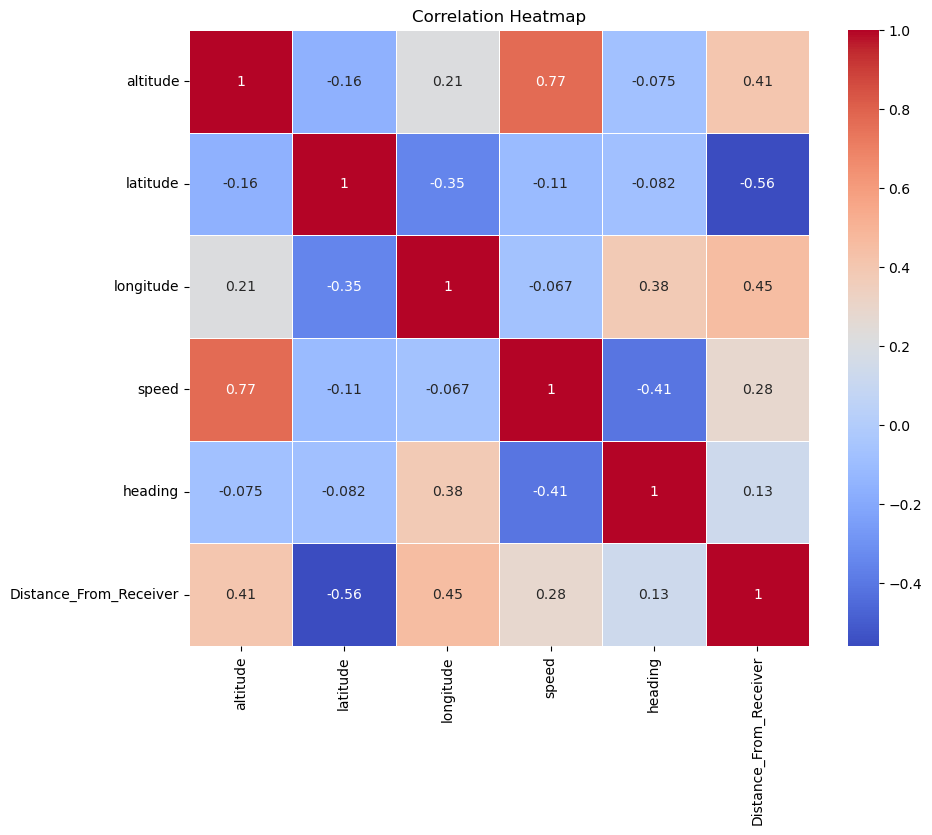

In [45]:
# correlation matrix
correlation_matrix = new_df[['altitude','latitude','longitude','speed','heading','Distance_From_Receiver']].corr()


# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Heatmap')
plt.show()


<p><b>The altitude and speed variables show a strong positive correlation. We can use a scatter plot to visualize this correlation.</b></p>

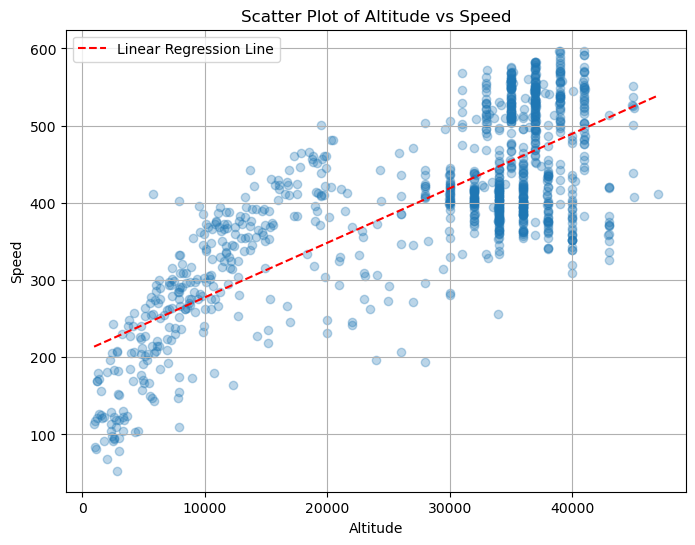

In [46]:
# scatter plot

plt.figure(figsize=(8, 6))  
plt.scatter(new_df['altitude'], new_df['speed'], alpha=0.3)
plt.title('Scatter Plot of Altitude vs Speed')
plt.xlabel('Altitude')
plt.ylabel('Speed')
plt.grid(True) 

# Fit a linear regression line

slope, intercept, r_value, p_value, std_err = linregress(new_df['altitude'], new_df['speed'])
x_values = np.array([min(new_df['altitude']), max(new_df['altitude'])])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='red', linestyle='--', label='Linear Regression Line')

plt.legend()
plt.show()



<p><b>Exploring some numerical features for possible outliers/anomalies.</b></p>

In [47]:
new_df['date'].min(),new_df['date'].max()

(Timestamp('2023-10-21 00:00:00'), Timestamp('2023-10-30 00:00:00'))

In [48]:
new_df[['altitude','speed','Distance_From_Receiver']].describe()

,altitude,speed,Distance_From_Receiver
count,1032.000000,1032.000000,1032.000000
mean,27857.485465,403.652132,24.773038
std,12460.879289,113.768914,13.830604
min,950.000000,53.000000,1.079852
25%,16662.500000,354.750000,14.243792
50%,34000.000000,407.500000,22.525379
75%,37000.000000,502.250000,32.357559
max,47000.000000,597.000000,72.902156


<p><b> A ground speed of 53 seems a bit low for an airplane, let's look more into it.</b></p>

In [49]:
def find_outliers_iqr(dataframe, column_to_check):
    """
    Identify outliers in a DataFrame column using the IQR (Interquartile Range) method.

    Parameters:
    - dataframe: pandas DataFrame
        The DataFrame containing the data to be checked for outliers.
    - column_to_check: str
        The name of the column in the DataFrame to check for outliers.

    Returns:
    - list
        A sorted list of outlier values in the specified column.
    """
    # Calculate the IQR (Interquartile Range)
    Q1 = dataframe[column_to_check].quantile(0.25)
    Q3 = dataframe[column_to_check].quantile(0.75)
    IQR = Q3 - Q1

    # Lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = dataframe[(dataframe[column_to_check] < lower_bound) | (dataframe[column_to_check] > upper_bound)]
    
    return sorted(list(outliers[column_to_check]))





In [50]:

speed_outliers = find_outliers_iqr(new_df, 'speed')

print("Speed Outliers:", speed_outliers)

Speed Outliers: [53, 68, 79, 81, 84, 92, 92, 94, 95, 96, 98, 103, 104, 104, 104, 110, 110, 113, 113, 117, 119, 119, 119, 121, 121, 122, 123, 123, 124, 125, 127, 129, 130]


<b> Vieiwing outliers records</b>

In [51]:
new_df[new_df['speed']<131].sort_values('speed')

,aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
358,9de8d4c87c8e3026c9269e90d88fc3c08b1e631a0edb04...,2023-10-25,01:21:43.591000,2850,38.48767,-90.01111,53,300,10.475733
248,61afc78a9f7dde56514650e11120e493237eb13d66b74e...,2023-10-24,22:27:00.460000,2000,38.61541,-90.01154,68,98,10.363686
345,0ef5e7a1966f20ad41fe2c461bdc3e35c9b08ba4e17afd...,2023-10-24,04:59:34.643000,2975,38.45403,-90.00949,79,269,13.247783
391,55937fc512aedaace51ea66b3e59a7c3e087c03f7209a3...,2023-10-24,00:24:33.087000,1100,38.54919,-89.88440,81,69,3.432304
23,25fb4790c94d71aee9d27cff5f63595c6abf0596790622...,2023-10-24,21:27:58.034000,1025,38.58861,-89.87324,84,166,5.949383
534,7d79a5551f38d3c9fde0a2e5d7950a4c78afc6c52d587e...,2023-10-22,18:30:14.190000,1800,38.50520,-89.99289,92,146,7.990720
75,2072c411945c62a630216a6658a9968ce822ab5229f6f7...,2023-10-27,22:05:53.000000,2475,38.59818,-89.98737,92,154,7.520902
729,899c5bb31d0cab564710425f1f2660c3234dfcc9e7ed14...,2023-10-22,17:55:37.290000,2575,38.53972,-90.04538,94,95,10.680119
528,b4737998fa7998b253f494472decdf5392a93cf04077cb...,2023-10-26,04:50:50.359000,2575,38.40727,-89.91509,95,73,16.157920
527,b4737998fa7998b253f494472decdf5392a93cf04077cb...,2023-10-24,00:53:45.819000,2950,38.45311,-90.07314,96,356,17.063833


<p><b> While a ground speed of 53 knots at an altitude of 2850 feet seems an anomaly, we can observe that most likely these lower values, although outliers, are most likely related to small, general aviation airplanes and should not be removed from the dataframe as they are part of the flight pattern in this region.</b></p>

In [52]:
altitude_outliers = find_outliers_iqr(new_df, 'altitude')


print("Altitude Outliers:", altitude_outliers)

Altitude Outliers: []


In [53]:
distance_outliers = find_outliers_iqr(new_df, 'Distance_From_Receiver')


print("Distance Outliers:", distance_outliers)

Distance Outliers: [59.86284544540165, 60.163590117817755, 60.307786439898756, 61.57674104947145, 61.589443950960245, 62.748022719456536, 62.837958747815556, 63.523572157909804, 64.20383932600383, 64.21564924553638, 64.75532652984332, 65.23473875899032, 65.83836776490892, 67.65238693342927, 67.83886851381297, 68.42269294159833, 68.93260138318782, 70.06901596871171, 70.62941224010511, 70.80297742333671, 71.95105565668912, 72.83138524897228, 72.90215628617665]


In [54]:
new_df[(new_df['Distance_From_Receiver']<72.91) & (new_df['Distance_From_Receiver']>=59)].sort_values('Distance_From_Receiver')

,aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
926,efeab977e6202702c960fccf7d89915e3c8c586275310f...,2023-10-25,14:06:06.152000,31975,38.22464,-89.38716,418,316,59.286058
915,df4d7acb319016f5013a93fa7f462d2be8343fcd936589...,2023-10-23,23:26:39.938000,38000,38.20584,-89.39814,390,231,59.862845
774,54635fadfeed16782c5e8d71acb66f648385e0a7ce4def...,2023-10-27,22:26:55.959000,34000,38.16962,-89.43600,417,315,60.163590
86,0107d730f880f9b3d6c9e4d8d4db4a214e3beb729e6c9e...,2023-10-21,05:00:23.382000,34000,38.18065,-89.42000,531,187,60.307786
973,d4605a3fe3fd24e71bac878618b0bbd4e41678b0f16fbd...,2023-10-23,02:10:02.088000,30000,38.12846,-89.46944,415,313,61.576741
384,b36d5869f7064701f4dc7a68d454df604b6e39bcf80bd2...,2023-10-28,17:33:22.436000,40000,38.21960,-89.35882,374,210,61.589444
545,cd27788fe3ca3d0eac99cff5bc7716de7ae9810c999c40...,2023-10-25,03:43:58.038000,36025,38.14807,-89.42173,376,271,62.748023
126,7390b4aff7ef8fca2781b9d60aed9b7690aa6d1dcc7cf4...,2023-10-30,01:19:52.616000,37000,38.25635,-89.30941,546,105,62.837959
954,ca8cdf10cabce6f59fb339409f2f71f1563daa42d5a690...,2023-10-21,02:08:13.459000,38000,38.18377,-89.36703,387,273,63.523572
1018,90039168bc372a2081e85d7fb7651577ee33ad20d93e45...,2023-10-26,23:10:21.630000,39000,38.11569,-89.44215,541,47,64.203839


<p><b> It is very possible that the ADSB receiver tends to receive more messages from airplanes that are closer to the receiving station; thus, these outliers should not be discarded from the analysis.</b></p>

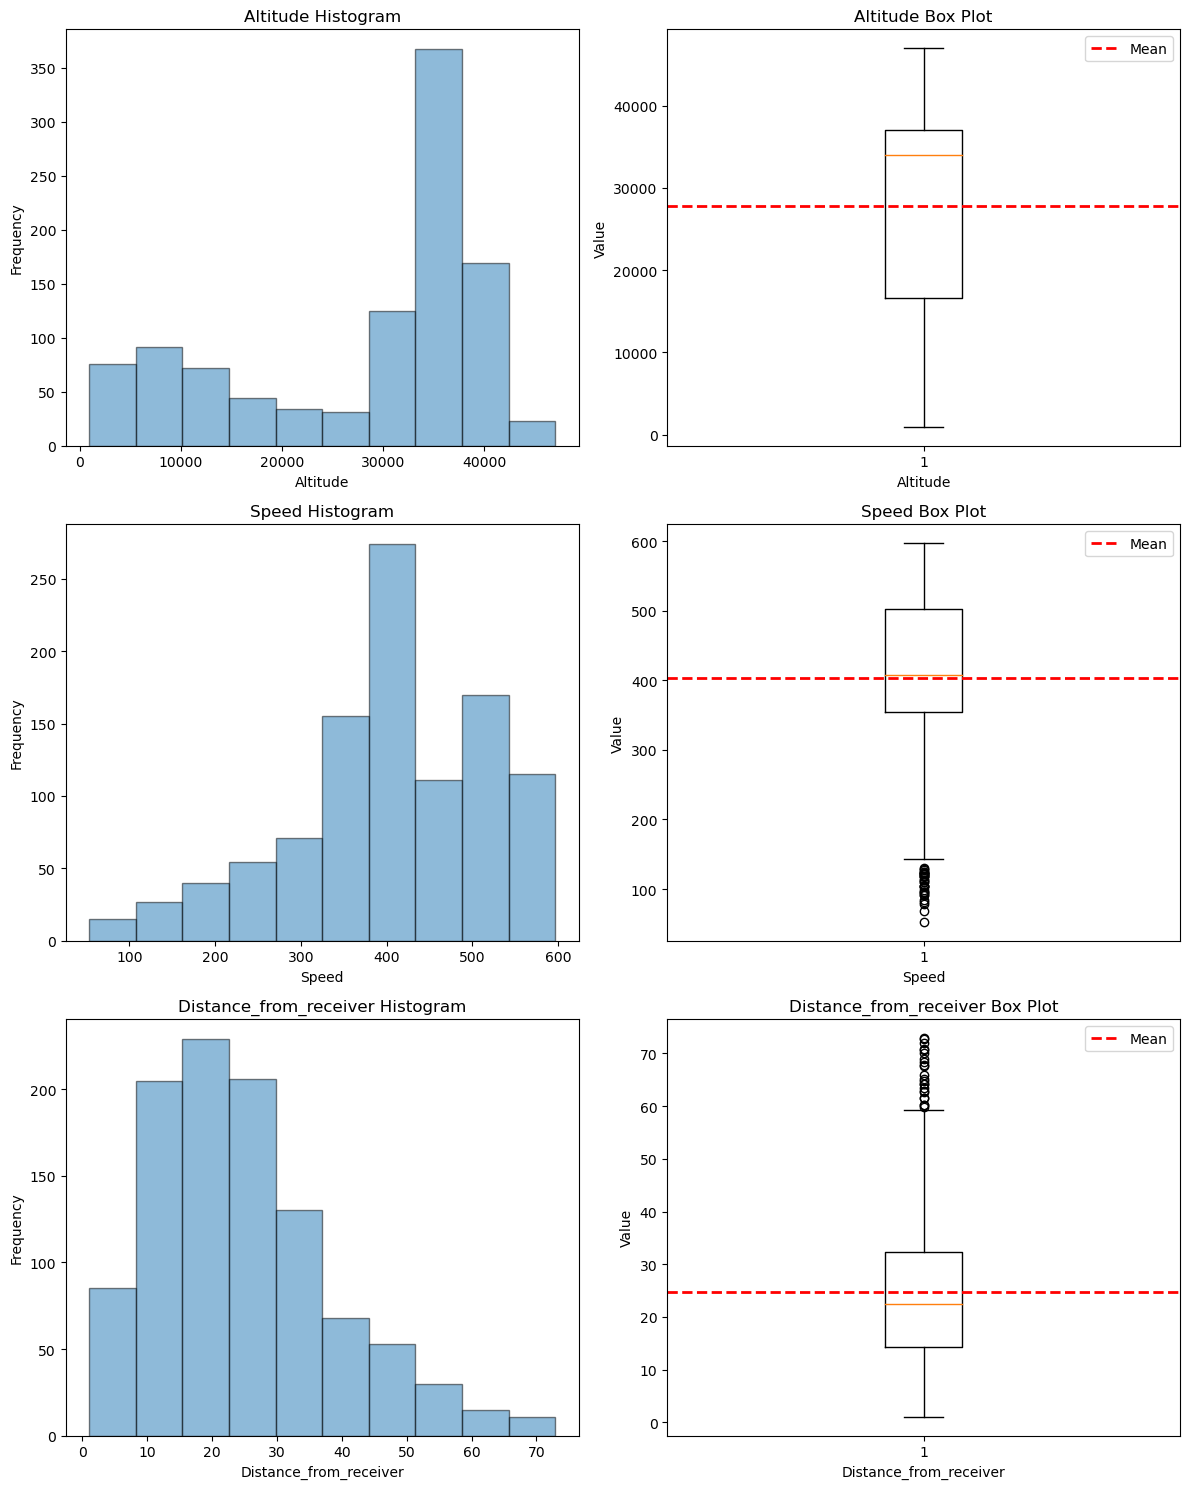

In [55]:
features = ['altitude', 'speed', 'Distance_From_Receiver']

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

for i, feature in enumerate(features):
    # Create histogram
    axes[i, 0].hist(new_df[feature], bins=10, edgecolor='black', alpha=0.5, label='Histogram')
    axes[i, 0].set_xlabel(feature.capitalize())
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].set_title(f'{feature.capitalize()} Histogram')

    # Create box plot
    axes[i, 1].boxplot(new_df[feature], showfliers=True)
    axes[i, 1].axhline(new_df[feature].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i, 1].set_xlabel(feature.capitalize())
    axes[i, 1].set_ylabel('Value')
    axes[i, 1].set_title(f'{feature.capitalize()} Box Plot')

    axes[i, 1].legend()

plt.tight_layout()
plt.show()


 <p style="text-align: justify;">The mean for the Altitude, as shown in the box-plot, is smaller than the median which indicates that the data distribution is negatively skewed. Negative skewness means that the tail of the distribution is longer on the left side (the lower values), and the bulk of the data is concentrated on the right side (the higher values)as we can observe in the histogram. Also the Box-Plot doesn't show the presence of any outliers in flight data. For the speed feature we notice that the mean and median are almost identical most likely because of the presence of outliers. Outliers can pull the mean and the median towards each other. For the field Distance_From_Receiver the mean is greater than the median indicating that the distribution of the data is positively skewed.This situation can occur when there are a few extremely large values (outliers which are shown in the box plot) that pull the mean to the right, while the median remains relatively unaffected by outliers because it represents the middle value when the data is sorted</p>

### Data Visualization

<p><b>Exploring the distribution of flights by days of the week </b></p>

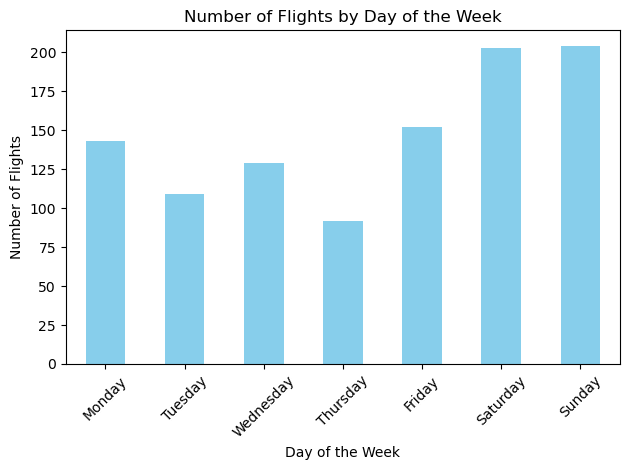

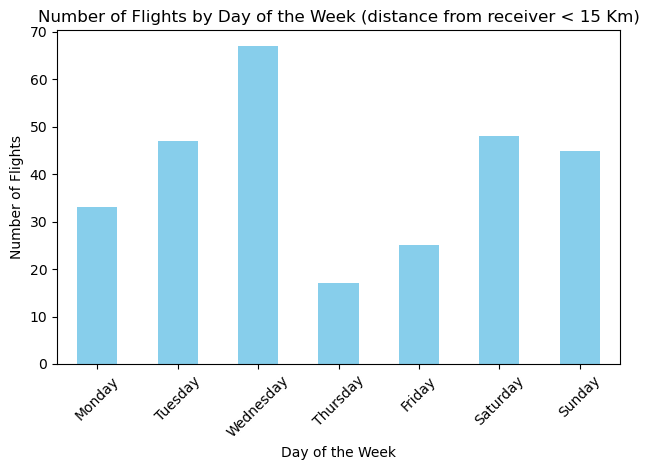

In [56]:
def plot_flight_count_by_day(df, title, filter_distance=False):
    """
    Plots the number of flights by day of the week.

    Args:
        df (DataFrame): The DataFrame containing flight data.
        title (str): The title of the plot.
        filter_distance (bool, optional): If True, filters flights with a distance from the receiver less than 15 Km.
            Default is False.

    Returns:
        None: The function displays the plot."""
    
    if filter_distance:
        filtered_df = df[df['Distance_From_Receiver'] < 15]
        title_suffix = ' (distance from receiver < 15 Km)'
    else:
        filtered_df = df
        title_suffix = ''

    flight_count_by_day = filtered_df['date'].dt.day_name().value_counts()
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    flight_count_by_day = flight_count_by_day.reindex(days_order)

    flight_count_by_day.plot(kind='bar', color='skyblue')
    plt.title(f'Number of Flights by Day of the Week{title_suffix}')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Flights')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_flight_count_by_day(new_df, 'All Flights')
plot_flight_count_by_day(new_df, 'All Flights', filter_distance=True)


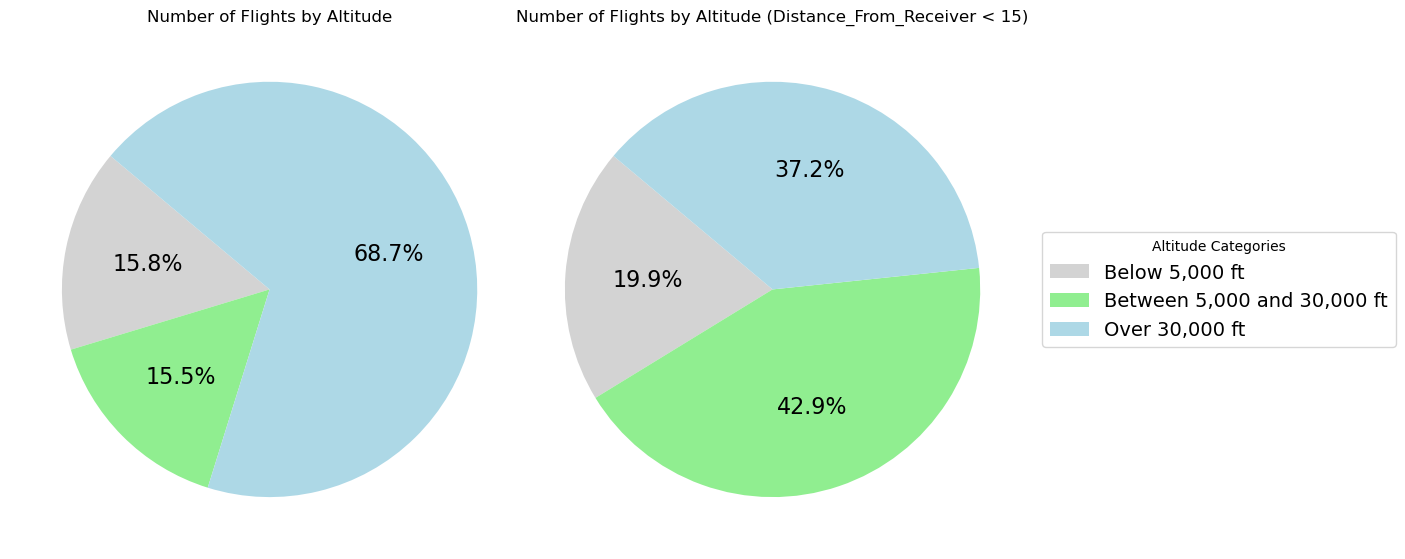

In [57]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Number of Flights by Altitude
below_10k = new_df[new_df['altitude'] < 10000]
between_10k_and_25k = new_df[(new_df['altitude'] >= 10000) & (new_df['altitude'] <= 25000)]
over_25k = new_df[new_df['altitude'] > 25000]
counts1 = [len(below_10k), len(between_10k_and_25k), len(over_25k)]
colors1 = ['lightgray', 'lightgreen', 'lightblue']
axes[0].pie(counts1, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 16},colors=colors1)
axes[0].set_aspect('equal')
axes[0].set_title('Number of Flights by Altitude')

# Second subplot: Number of Flights by Altitude (filtered)
filtered_df = new_df[new_df['Distance_From_Receiver'] < 15]
below_5k = filtered_df[filtered_df['altitude'] < 5000]
between_5k_and_15k = filtered_df[(filtered_df['altitude'] >= 5000) & (filtered_df['altitude'] <= 30000)]
over_15k = filtered_df[filtered_df['altitude'] > 30000]
counts2 = [len(below_5k), len(between_5k_and_15k), len(over_15k)]
altitude_labels = ['Below 5,000 ft', 'Between 5,000 and 30,000 ft', 'Over 30,000 ft']
axes[1].pie(counts2, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 16},colors=['lightgray', 'lightgreen', 'lightblue'])
axes[1].set_aspect('equal')
axes[1].set_title('Number of Flights by Altitude (Distance_From_Receiver < 15)')
plt.legend(altitude_labels, title='Altitude Categories', loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':14})



plt.tight_layout()
plt.show()


<p><b> View of flights over a regional map by flight level (Low Altitude (Green), Medium Altitude (Blue), and High Altitude (Red). The map also shows the ADSB receiver location and two Airports (St Louis Lambert International and St Louis MidAmerica).</b></p>

In [86]:
# Airport coordinates
airport1 = {
    'latitude': 38.748629,
    'longitude': -90.370021
}

airport2 = {
    'latitude': 38.5343, 
    'longitude': -89.8645
}

# Create a Folium Map
m = folium.Map(location=[fixed_place['latitude'], fixed_place['longitude']], zoom_start=10)

def get_color(altitude):
    '''
    Function to assign a color based on altitude
    '''
    if altitude < 10000:
        return 'green'  # Low altitude (up to 10,000 feet)
    elif altitude < 20000:
        return 'blue'  # Medium altitude (10,000 to 20,000 feet)
    else:
        return 'red'  # High altitude (above 20,000 feet)

# Add markers for aircraft positions
for _, row in new_df.iterrows():
    color = get_color(row['altitude'])
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
    ).add_to(m)

# Add a marker for ADSB
folium.Marker(
    location=[fixed_place['latitude'], fixed_place['longitude']],
    icon=folium.Icon(color='orange', icon='home'),
    popup='My House'
).add_to(m)

# Add markers for the airports
folium.Marker(
    location=[airport1['latitude'], airport1['longitude']],
    icon=folium.Icon(color='pink', icon='plane'),
    popup='Airport 1'
).add_to(m)

folium.Marker(
    location=[airport2['latitude'], airport2['longitude']],
    icon=folium.Icon(color='pink', icon='plane'),
    popup='Airport 2'
).add_to(m)

# Save the map as an HTML file
#m.save('aircraft_positions_map.html')

# Display the map
m


<p><b>Visualize the geographic distribution of flights represented by latitude and longitude coordinates with a Heatmap. This is useful for understanding the density and concentration of data points in different regions on a map.</b></p>

In [87]:
m = folium.Map(location=[new_df['latitude'].mean(), new_df['longitude'].mean()], zoom_start=4)

# Generate a heatmap layer
heat_data = [[row['latitude'], row['longitude']] for index, row in new_df.iterrows()]
HeatMap(heat_data,alpha=0.5).add_to(m)

# Display the map 
m

## Data Pre-Pocessing

 <p style="text-align: justify;">We will conduct scaling which aims to standardize or normalize the numeric features within a dataset. It ensures that the features have similar scales or units, making them compatible for certain machine learning algorithms like k-means.</p>

In [60]:
new_df.head()

,aircraft_icao_id,date,timestamp,altitude,latitude,longitude,speed,heading,Distance_From_Receiver
0,ae1acd3c96ca339c5a751a84414d159d851c1ed5467088...,2023-10-26,20:06:24.878000,35000,38.61955,-90.12807,510,131,19.271622
1,0558783c508dd8ceb8f9bde499f63ccfdf1f77eace6ad0...,2023-10-21,02:25:26.486000,40000,38.84384,-90.11713,487,202,36.495388
2,891029be8c1a1d09c626a8623b6672bd11cb79b558d6a4...,2023-10-22,01:47:50.346000,37975,38.55801,-89.70074,415,206,19.393315
3,5c075566142f83bda2d7dfb4e588df0301700c9c8f4785...,2023-10-21,22:35:01.245000,37950,38.66107,-90.23029,432,214,29.255380
4,077ac534a657b6d2fe1fff7572b3bd1fdc60b0941ecd84...,2023-10-22,03:41:21.108000,36025,38.72662,-89.94680,435,210,19.473439


In [61]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   aircraft_icao_id        1032 non-null   object        
 1   date                    1032 non-null   datetime64[ns]
 2   timestamp               1032 non-null   object        
 3   altitude                1032 non-null   int64         
 4   latitude                1032 non-null   float64       
 5   longitude               1032 non-null   float64       
 6   speed                   1032 non-null   int64         
 7   heading                 1032 non-null   int64         
 8   Distance_From_Receiver  1032 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 72.7+ KB


In [62]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()
scaler.fit(new_df[['speed','altitude']])
scaled_data = scaler.transform(new_df[['speed','altitude']])


In [63]:
# Convert the scaled data array into a DataFrame
scaled_df = pd.DataFrame(data=scaled_data, columns=['speed','altitude'])



## Fit and Evaluate K-means model


<p><b>K-Means is a popular clustering algorithm used in machine learning and data analysis. The primary assumption of K-Means is that it assigns data points to clusters based on their proximity to the cluster's centroid. It assumes that data points within a cluster are closer to each other than to data points in other clusters. K-Means also assumes that clusters are spherical, equally sized, and have similar densities. 

However, K-Means has some limitations. It may not perform well when clusters have irregular shapes, varying sizes, or different densities. The algorithm's performance is sensitive to the initial placement of cluster centroids, which can lead to suboptimal solutions. Additionally, it is essential to predefine the number of clusters (k), which can be challenging when the true number of clusters is unknown. Finally, K-Means is sensitive to outliers, which can significantly impact the clustering results. Therefore, understanding the assumptions and limitations of K-Means is crucial for its successful application in clustering tasks.</b></p>

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("default")

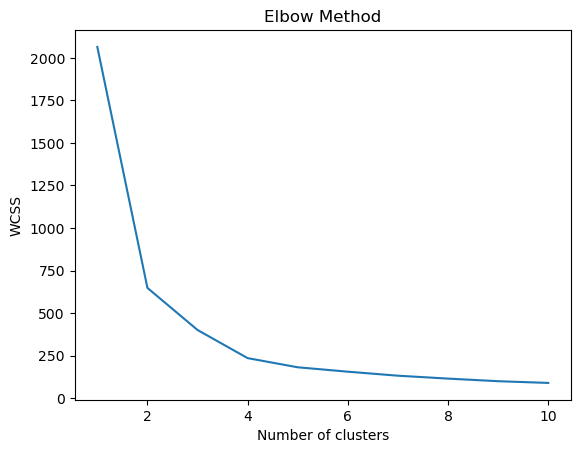

In [65]:
wcss = []  # Within-cluster sum of squares

for i in range(1, 11):
    
    kmeans_scaled = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_scaled.fit(scaled_df[['speed','altitude']])
    wcss.append(kmeans_scaled.inertia_)
    
# Plot the Elbow graph to determine the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  
plt.show()

<p>The elbow method works by calculating the within-cluster sum of squares (WCSS) for different values of K (the number of clusters). The WCSS is a measure of how spread out the data points are within each cluster. The lower the WCSS, the more tightly clustered the data points are.
The elbow method plots the WCSS versus K. The optimal number of clusters is the value of K at which the WCSS starts to decrease more slowly. This is because, beyond this point, adding additional clusters does not provide a significant reduction in the WCSS.</p>

In [66]:
warnings.filterwarnings("ignore", category=FutureWarning)
kmeans_scaled = KMeans(n_clusters=2, random_state=0)  # You can choose the number of clusters

# Fit the model on scaled dataset
kmeans_scaled.fit(scaled_df[['speed','altitude']])

# Get the cluster labels for each data point
cluster_labels = kmeans_scaled.labels_

# Assign the cluster labels 
scaled_df['cluster'] = cluster_labels



<p>Data scaling in the context of K-means is the process of transforming the data so that all of the features have the same scale. This is important because K-means works by minimizing the distance between data points and cluster centers. If the features have different scales, then the distance metric will be biased towards the features with the largest scales. In this case we are using Standardization technique which scales the data so that all of the features have a mean of 0 and a standard deviation of 1.</p>

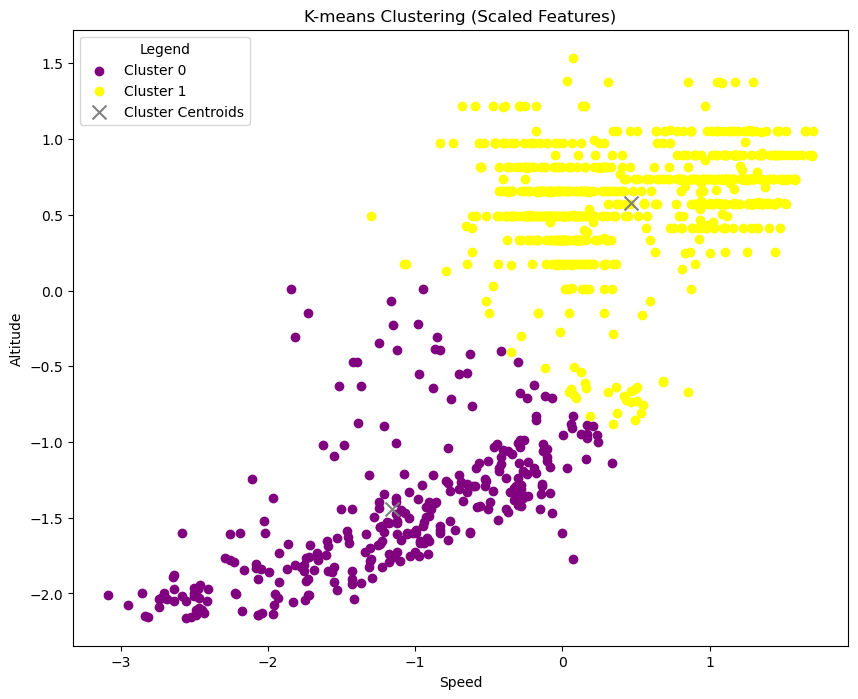

In [67]:
# Scatter plot of K-means clusters (scaled)
plt.figure(figsize=(10, 8))

# Scatter plot for Cluster 0
plt.scatter(scaled_df[cluster_labels == 0]['speed'], scaled_df[cluster_labels == 0]['altitude'], c='purple', label='Cluster 0')

# Scatter plot for Cluster 1
plt.scatter(scaled_df[cluster_labels == 1]['speed'], scaled_df[cluster_labels == 1]['altitude'], c='yellow', label='Cluster 1')

# Scatter plot of cluster centroids
plt.scatter(kmeans_scaled.cluster_centers_[:, 0], kmeans_scaled.cluster_centers_[:, 1], color='gray', s=100, marker='x', label='Cluster Centroids')

plt.xlabel('Speed')
plt.ylabel('Altitude')
plt.title('K-means Clustering (Scaled Features)')

plt.legend(loc='best', markerscale=1, title='Legend')

plt.show()


<p>We are using the Silhouette Score, and Calinski-Harabasz Index (C-score) as measures of the quality of clustering.
<ul><li> The Silhouette Score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It quantifies the quality and separation of clusters.The score ranges from -1 to 1. A silhouette Score close to 1 suggests that the object is appropriately clustered while a sore close to 0 suggests that the object is on or very close to the decision boundary between two neighboring clusters.Lastly a negative score indicates that the object may have been assigned to the wrong cluster.<li> The Calinski-Harabasz Index is a measure of the ratio of between-cluster variance to within-cluster variance.It assesses the separation between clusters. A higher C-score indicates better-defined, well-separated clusters.A negative score suggests that the clusters may have a higher degree of overlap or that the data points are not as clearly separated into distinct clusters</li></li></ul></p>

In [68]:
# Calculate the silhouette score
km_scaled_silhouette_avg = silhouette_score(scaled_df[['speed','altitude']],scaled_df['cluster'])

print(f"Silhouette Score: {km_scaled_silhouette_avg}")

Silhouette Score: 0.6229531673055853


In [69]:
X = scaled_df[['speed', 'altitude']]
cluster_labels = scaled_df['cluster']

# Calculate the C-score
km_scaled_c_score = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Index (C-score): {km_scaled_c_score}")


Calinski-Harabasz Index (C-score): 2251.3541998901164


<p><b>Using the same features for kmeans without scaling them.</b> </p>

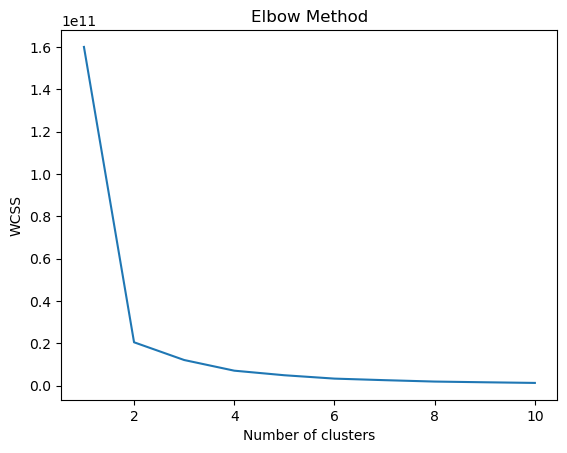

In [70]:
wcss = []  

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(new_df[['speed','altitude']])
    wcss.append(kmeans.inertia_)
    
# Plot the Elbow graph to determine the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  
plt.show()

In [71]:
# Use K-means for clustering
warnings.filterwarnings("ignore", category=FutureWarning)
kmeans = KMeans(n_clusters=2, random_state=0)  # You can choose the number of clusters

# Fit the model on the dataset
kmeans.fit(new_df[['speed','altitude']])
#scaled_data['cluster'] = kmeans.predict(scaled_data)
# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Assign the cluster labels to DataFrame
new_df['cluster'] = cluster_labels




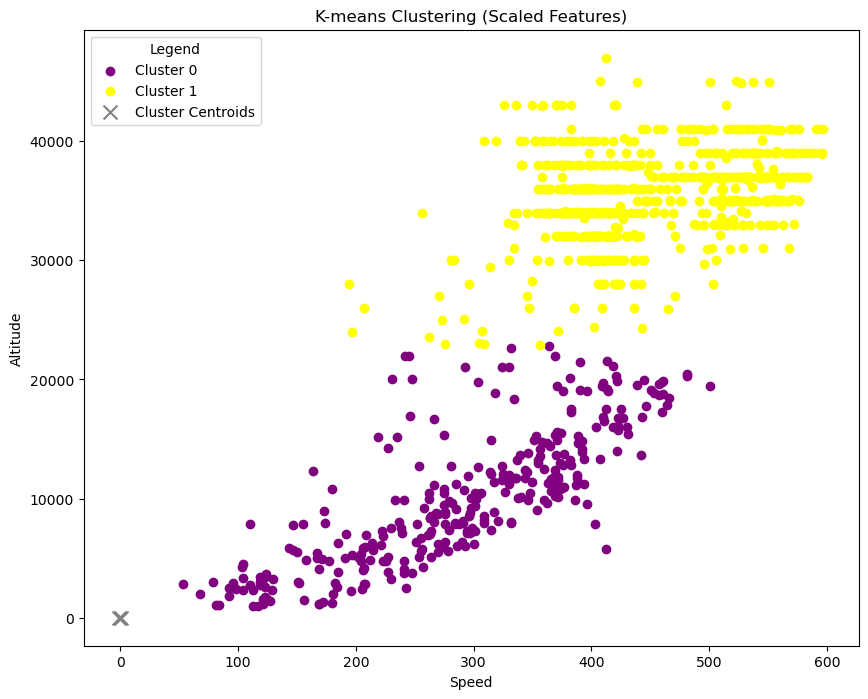

In [72]:
# Scatter plot of K-means clusters (scaled)
plt.figure(figsize=(10, 8))

# Scatter plot for Cluster 0
plt.scatter(new_df[cluster_labels == 0]['speed'], new_df[cluster_labels == 0]['altitude'], c='purple', label='Cluster 0')

# Scatter plot for Cluster 1
plt.scatter(new_df[cluster_labels == 1]['speed'], new_df[cluster_labels == 1]['altitude'], c='yellow', label='Cluster 1')

# Scatter plot of cluster centroids
plt.scatter(kmeans_scaled.cluster_centers_[:, 0], kmeans_scaled.cluster_centers_[:, 1], color='gray', s=100, marker='x', label='Cluster Centroids')

plt.xlabel('Speed')
plt.ylabel('Altitude')
plt.title('K-means Clustering (Scaled Features)')

plt.legend(loc='best', markerscale=1, title='Legend')

plt.show()


In [73]:
# Calculate the silhouette score
km_silhouette_avg = silhouette_score(new_df[['speed','altitude']], new_df['cluster'])

print(f"Silhouette Score: {km_silhouette_avg}")


Silhouette Score: 0.791440646078374


In [74]:
X = new_df[['speed', 'altitude']]
cluster_labels = new_df['cluster']

# Calculate the C-score
km_c_score = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Index (C-score): {km_c_score}")


Calinski-Harabasz Index (C-score): 7023.031759604773


<p><b> Overall, the model with unscaled data has better Silhouette Score, and Calinski-Harabasz Index (C-score) than the first model. However, this might be due to collinearity between the features speed and altitude. Scaling the data might break down those relationships and make it harder for the algorithm to capture the underlying structure of the data.</b></p> 

## Fitting and Evaluating Mean Shift

<p><b>Mean Shift is a non-parametric clustering algorithm used in machine learning and data analysis. It's a density-based clustering technique that automatically identifies and groups data points into clusters without requiring the number of clusters as an input. The algorithm works by iteratively shifting each data point toward the mean of nearby data points until it converges to a local mode, which represents a cluster center. Mean Shift is effective at identifying clusters with irregular shapes and varying densities in the data. It's often used for tasks like image segmentation, object tracking, and spatial data analysis.</b></p>

Bandwidth: 0.1, Silhouette Score: 0.4272746498135973, C-score: 2796.6337193313466
Bandwidth: 0.2, Silhouette Score: 0.4272746498135973, C-score: 2796.6337193313466
Bandwidth: 0.30000000000000004, Silhouette Score: 0.4272746498135973, C-score: 2796.6337193313466
Bandwidth: 0.4, Silhouette Score: 0.5132991972495227, C-score: 1525.8389941984449
Bandwidth: 0.5, Silhouette Score: 0.5132991972495227, C-score: 1525.8389941984449
Bandwidth: 0.6, Silhouette Score: 0.5132991972495227, C-score: 1525.8389941984449
Bandwidth: 0.7000000000000001, Silhouette Score: 0.6157492649961933, C-score: 2203.942652592716
Bandwidth: 0.8, Silhouette Score: 0.6157492649961933, C-score: 2203.942652592716
Bandwidth: 0.9, Silhouette Score: 0.6198519313094825, C-score: 2226.780623795215
Bandwidth: 1.0, Silhouette Score: 0.6198519313094825, C-score: 2226.780623795215

Best Silhouette Score is 0.6198519313094825, the best number of clusters is 2, and the calinski_harabasz is 2226.780623795215 


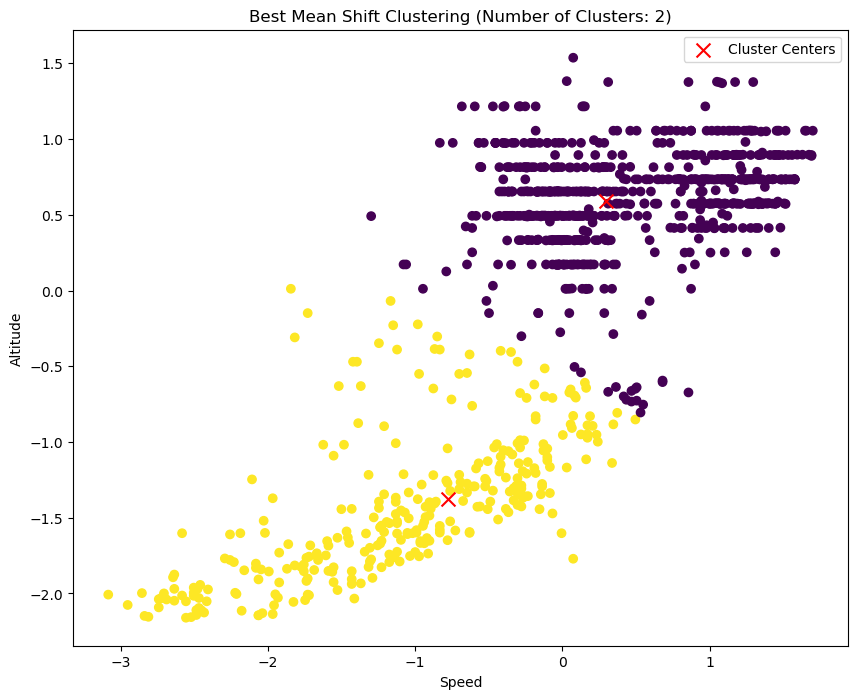

In [75]:
from sklearn.cluster import MeanShift

# Define the range of bandwidth values to explore
bandwidth_range = np.linspace(0.1, 1, num=10)
scaled_best_silhouette_score = -1  # Initialize with a very low value
best_bandwidth = None
scaled_best_c_score = -1

for bandwidth in bandwidth_range:
    # Create and fit the Mean Shift model with the specified bandwidth
    meanshift = MeanShift(bandwidth=bandwidth)
    labels = meanshift.fit_predict(scaled_data)

    # Calculate the silhouette score for the current clustering
    silhouette_avg = silhouette_score(scaled_data, labels)
    
    # Calculate Calinski-Harabasz Index (C-score)
    calinski_harabasz = calinski_harabasz_score(scaled_data, labels)

    # Check if the current silhouette score is the best so far
    if silhouette_avg > scaled_best_silhouette_score:
        scaled_best_silhouette_score = silhouette_avg
        scaled_best_c_score= calinski_harabasz
        best_bandwidth = bandwidth
    print(f"Bandwidth: {bandwidth}, Silhouette Score: {scaled_best_silhouette_score}, C-score: {scaled_best_c_score}")


# Mean Shift model with the best bandwidth
best_meanshift = MeanShift(bandwidth=best_bandwidth)
best_labels = best_meanshift.fit_predict(scaled_data)
best_cluster_centers = best_meanshift.cluster_centers_
best_n_clusters = len(best_cluster_centers)


print("")
print(f"Best Silhouette Score is {scaled_best_silhouette_score}, the best number of clusters is {best_n_clusters}, and the calinski_harabasz is {scaled_best_c_score} ")

# Create a scatter plot of the data points and cluster centers for the best model
plt.figure(figsize=(10, 8))
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=best_labels, cmap='viridis')
plt.scatter(best_cluster_centers[:, 0], best_cluster_centers[:, 1], marker='x', color='red', s=100, label='Cluster Centers')
plt.title(f'Best Mean Shift Clustering (Number of Clusters: {best_n_clusters})')
plt.xlabel('Speed')
plt.ylabel('Altitude')
plt.legend()
plt.show()


In [77]:
print(f"Silhouette Score is {scaled_best_silhouette_score}, and the calinski_harabasz is {scaled_best_c_score} ")


Silhouette Score is 0.6198519313094825, and the calinski_harabasz is 2226.780623795215 


In [80]:
table = PrettyTable()
data = [
    {"Bandwidth": 0.1, "Silhouette Score": 0.4272746498135973, "C-score": 2796.6337193313466},
    {"Bandwidth": 0.2, "Silhouette Score": 0.4272746498135973, "C-score": 2796.6337193313466},
    {"Bandwidth": 0.30000000000000004, "Silhouette Score": 0.4272746498135973, "C-score": 2796.6337193313466},
    {"Bandwidth": 0.4, "Silhouette Score": 0.5132991972495227, "C-score": 1525.8389941984449},
    {"Bandwidth": 0.5, "Silhouette Score": 0.5132991972495227, "C-score": 1525.8389941984449},
    {"Bandwidth": 0.6, "Silhouette Score": 0.5132991972495227, "C-score": 1525.8389941984449},
    {"Bandwidth": 0.7000000000000001, "Silhouette Score": 0.6157492649961933, "C-score": 2203.942652592716},
    {"Bandwidth": 0.8, "Silhouette Score": 0.6157492649961933, "C-score": 2203.942652592716},
    {"Bandwidth": 0.9, "Silhouette Score": 0.6198519313094825, "C-score": 2226.780623795215},
    {"Bandwidth": 1.0, "Silhouette Score": 0.6198519313094825, "C-score": 2226.780623795215}
]




df5 = pd.DataFrame(data)

table.field_names = df5.columns
for row in df5.itertuples(index=False):
    table.add_row(row)

display(HTML(df5.to_html()))

,Bandwidth,Silhouette Score,C-score
0,0.1,0.427275,2796.633719
1,0.2,0.427275,2796.633719
2,0.3,0.427275,2796.633719
3,0.4,0.513299,1525.838994
4,0.5,0.513299,1525.838994
5,0.6,0.513299,1525.838994
6,0.7,0.615749,2203.942653
7,0.8,0.615749,2203.942653
8,0.9,0.619852,2226.780624
9,1.0,0.619852,2226.780624


<p><b> Fitting Mean Shift on non-scaled data.</b></p>

Bandwidth: 1000.0, Silhouette Score: 0.6307453343906733, C-score: 29382.052310479892
Bandwidth: 2000.0, Silhouette Score: 0.5269832979414965, C-score: 11435.108805248949
Bandwidth: 3000.0, Silhouette Score: 0.510118899511236, C-score: 4782.583713146948
Bandwidth: 4000.0, Silhouette Score: 0.6573031294832437, C-score: 5877.647875679121
Bandwidth: 5000.0, Silhouette Score: 0.791411136661015, C-score: 7018.157427100431
Bandwidth: 6000.0, Silhouette Score: 0.7907011851545465, C-score: 6973.466713902799
Bandwidth: 7000.0, Silhouette Score: 0.7907011851545465, C-score: 6973.466713902799
Bandwidth: 8000.0, Silhouette Score: 0.7907011851545465, C-score: 6973.466713902799
Bandwidth: 9000.0, Silhouette Score: 0.791411136661015, C-score: 7018.157427100431
Bandwidth: 10000.0, Silhouette Score: 0.791411136661015, C-score: 7018.157427100431
Best bandwidth is 5000.0, best Silhouette Score is 0.791411136661015, and the best number of clusters is 2, C-score is 7018.157427100431


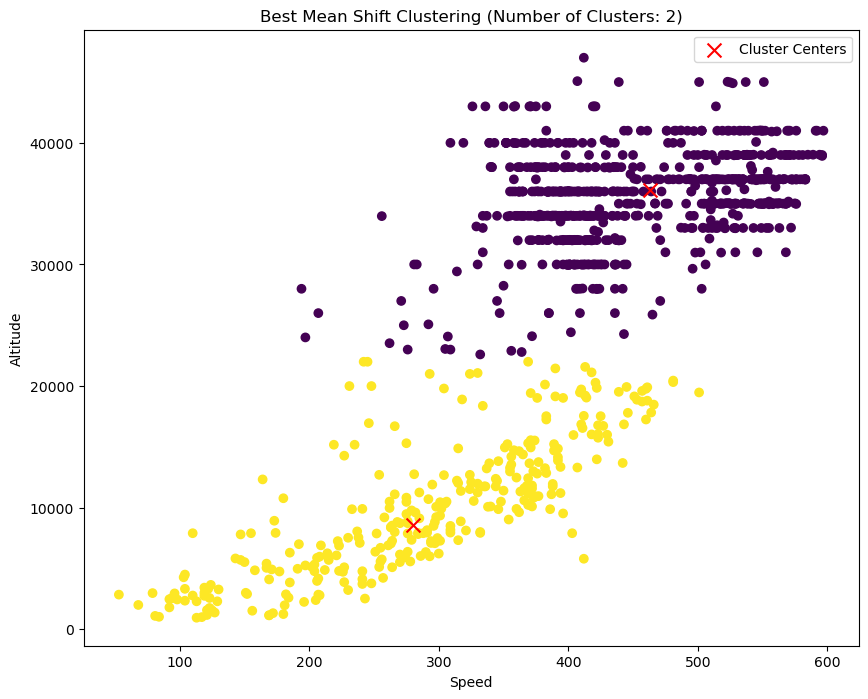

In [81]:
# Define the range of bandwidth values to explore

bandwidth_range = np.linspace(1000, 10000, num=10)
best_silhouette_score = -1  # Initialize with a very low value
best_c_score = -1
best_bandwidth = None

for bandwidth in bandwidth_range:
    # Create and fit the Mean Shift model with the specified bandwidth
    meanshift = MeanShift(bandwidth=bandwidth)
    labels = meanshift.fit_predict(new_df[['speed','altitude']])

    # Calculate the silhouette score for the current clustering
    silhouette_avg = silhouette_score(new_df[['speed','altitude']], labels)

    # Calculate Calinski-Harabasz Index (C-score)
    calinski_harabasz = calinski_harabasz_score(new_df[['speed','altitude']], labels)

    # Check if the current silhouette score is the best so far
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_c_score = calinski_harabasz
        best_bandwidth = bandwidth

    # Print the results for the current bandwidth
    print(f"Bandwidth: {bandwidth}, Silhouette Score: {silhouette_avg}, C-score: {calinski_harabasz}")

# After the loop, best_bandwidth will contain the bandwidth with the best silhouette score

# Create the Mean Shift model with the best bandwidth
best_meanshift = MeanShift(bandwidth=best_bandwidth)
best_labels = best_meanshift.fit_predict(new_df[['speed','altitude']])
best_cluster_centers = best_meanshift.cluster_centers_
best_n_clusters = len(best_cluster_centers)

print(f"Best bandwidth is {best_bandwidth}, best Silhouette Score is {best_silhouette_score}, and the best number of clusters is {best_n_clusters}, C-score is {best_c_score}")

# Create a scatter plot of the data points and cluster centers for the best model
plt.figure(figsize=(10, 8))
plt.scatter(new_df['speed'], new_df['altitude'], c=best_labels, cmap='viridis')
plt.scatter(best_cluster_centers[:, 0], best_cluster_centers[:, 1], marker='x', color='red', s=100, label='Cluster Centers')
plt.title(f'Best Mean Shift Clustering (Number of Clusters: {best_n_clusters})')
plt.xlabel('Speed')
plt.ylabel('Altitude')
plt.legend()
plt.show()


In [94]:
print(f"Silhouette Score is {best_silhouette_score}, and C-score is {best_c_score}")


Silhouette Score is 0.791411136661015, and C-score is 7018.157427100431


In [82]:

table = PrettyTable()
table.field_names = ["Model Name", "Silhouette Score", "Calinski-Harabasz (C-score)"]


results = [
    ("K-means (scaled values)", km_scaled_silhouette_avg, km_scaled_c_score),
    ("K-means (non scaled)", km_silhouette_avg, km_c_score),
    ("Mean Shift (scaled values)", scaled_best_silhouette_score, scaled_best_c_score),
    ("Mean Shift (non scaled)", best_silhouette_score, best_c_score)
]

for result in results:
    table.add_row(result)

table.align["Model Name"] = "l"  
table.align["Silhouette Score"] = "c"  
table.align["Calinski-Harabasz (C-score)"] = "c" 

# Render the table in a Pandas DataFrame-like layout
display(HTML(table.get_html_string()))


Model Name,Silhouette Score,Calinski-Harabasz (C-score)
K-means (scaled values),0.6229531673055853,2251.3541998901164
K-means (non scaled),0.791440646078374,7023.031759604773
Mean Shift (scaled values),0.6198519313094825,2226.780623795215
Mean Shift (non scaled),0.791411136661015,7018.157427100431


### Models Evaluation

In [84]:

cluster_stats = scaled_df.groupby('cluster')[['speed', 'altitude']].describe()

# Create a PrettyTable to display cluster profiles
cluster_profiles = PrettyTable()
cluster_profiles.field_names = ["Cluster", "Speed Range", "Average Speed", "Altitude Range", "Average Altitude"]

for cluster_no in range(2):
    if cluster_no in cluster_stats.index:
        cluster_profiles.add_row([
            cluster_no,
            f"{cluster_stats.loc[cluster_no]['speed']['min']} - {cluster_stats.loc[cluster_no]['speed']['max']}",
            cluster_stats.loc[cluster_no]['speed']['mean'],
            f"{cluster_stats.loc[cluster_no]['altitude']['min']} - {cluster_stats.loc[cluster_no]['altitude']['max']}",
            cluster_stats.loc[cluster_no]['altitude']['mean']
        ])
    else:
        cluster_profiles.add_row([
            cluster_no + 1,
            'N/A',
            'N/A',
            'N/A',
            'N/A'
        ])

html_table = cluster_profiles.get_html_string()


display(HTML(html_table))


Cluster,Speed Range,Average Speed,Altitude Range,Average Altitude
0,-3.083637988943576 - 0.3372314967196835,-1.1568884513756663,-2.160403844293745 - 0.011442501731708958,-1.43999713821262
1,-1.2984541699470677 - 1.7003028856086428,0.4652703554445616,-0.8837917591993008 - 1.5369537983854475,0.5791292838463798



### Statisical Analysis

In order to establish the statistical significance of the noted variances in mean altitude and speed between Cluster 0 and Cluster 1, it is essential to validate that these distinctions are not merely outcomes of random chance. The Mann-Whitney U test, a non-parametric statistical test, becomes relevant in this context. This test is employed to compare the means from two independent samples originating from the same population, determining whether there exists a significant difference between the two sample means. Typically, the Mann-Whitney U test is preferred when dealing with ordinal data or when the assumptions of a t-test are not satisfied.
The Mann-Whitney U test operates without assuming specific properties of the score distribution. Key assumptions include the randomness of the sample drawn from the population, independence within and between samples, and the ordinal nature of the measurement scale. These assumptions contribute to the robustness and applicability of the Mann-Whitney U test, particularly when dealing with data that may not conform to the requirements of parametric tests.

In [85]:

from scipy.stats import mannwhitneyu
# Extract data for each cluster
cluster_0_speed = scaled_df[scaled_df['cluster'] == 0]['speed']
cluster_1_speed = scaled_df[scaled_df['cluster'] == 1]['speed']

cluster_0_altitude = scaled_df[scaled_df['cluster'] == 0]['altitude']
cluster_1_altitude = scaled_df[scaled_df['cluster'] == 1]['altitude']

# Perform Mann-Whitney U test for speed
mannwhitneyu_speed, p_value_speed = mannwhitneyu(cluster_0_speed, cluster_1_speed)

# Perform Mann-Whitney U test for altitude
mannwhitneyu_altitude, p_value_altitude = mannwhitneyu(cluster_0_altitude, cluster_1_altitude)

# Create a PrettyTable to display Mann-Whitney U test results
table = PrettyTable()
table.field_names = ["Test", "U Statistic", "P-value"]
table.add_row(["Speed", mannwhitneyu_speed, p_value_speed])
table.add_row(["Altitude", mannwhitneyu_altitude, p_value_altitude])

# Generate an HTML representation of the table
html_table = table.get_html_string()


display(HTML(html_table))


Test,U Statistic,P-value
Speed,9992.0,1.597513749447888e-115
Altitude,767.5,7.048632059055148e-138



The results of the Mann-Whitney U test indicate that there is a statistically significant difference in both speed and altitude between Cluster 0 and Cluster 1. The p-values for both tests are very small, which means that there is a very low probability of obtaining these results by chance. 